# Face Recognition Project

In [1]:
import os
import sys
import cv2
import numpy as np
import time
import torchvision
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
import seaborn as sns

from collections import defaultdict
from pathlib import Path
from torch.optim import lr_scheduler
from torch import nn
from tqdm.autonotebook import trange
from tqdm.notebook import tqdm
from torchvision import datasets, models, transforms
from tabulate import tabulate
from PIL import Image
from skimage import io, transform
from torch.utils.data import Dataset

In [2]:
! git clone https://github.com/timesler/facenet-pytorch.git
! mv facenet-pytorch/models ./
!pip install facenet-pytorch
from facenet_pytorch import  InceptionResnetV1

Cloning into 'facenet-pytorch'...
remote: Enumerating objects: 1332, done.
remote: Counting objects: 100% (287/287), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 1332 (delta 229), reused 224 (delta 214), pack-reused 1045
Receiving objects: 100% (1332/1332), 23.18 MiB | 10.71 MiB/s, done.
Resolving deltas: 100% (658/658), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 53.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-man

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
!unzip -q /content/gdrive/MyDrive/celebA_train_500.zip

In [5]:
import os
from sklearn.model_selection import train_test_split
from collections import defaultdict
from shutil import copyfile

# Путь к папке с выровненными картинками
celebA_imgs_path = './celebA_train_500/celebA_imgs/'

# Путь к файлу с аннотацией (celebA_anno.txt)
anno_file_path = './celebA_train_500/celebA_anno.txt'

# Путь к файлу со сплитом на train/val/test (celebA_train_split.txt)
split_file_path = './celebA_train_500/celebA_train_split.txt'

# Создаем папки для тренировочной, валидационной и тестовой выборок
train_path = './celebA_train_500/train/'
val_path = './celebA_train_500/val/'
test_path = './celebA_train_500/test/'
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Загружаем аннотации
f = open(anno_file_path, 'r')
anno_lines = f.readlines()
f.close()
anno_lines = [x.strip().split(' ') for x in anno_lines]
anno_dict = {img_name: img_class for img_name, img_class in anno_lines}

# Загружаем информацию о сплите
f = open(split_file_path, 'r')
split_lines = f.readlines()
f.close()
split_lines = [x.strip().split(' ') for x in split_lines]

# Создаем списки для train, val, test
train_list, val_list, test_list = [], [], []

for img_name, split_type in split_lines:
    if split_type == '0':  # 0 - тренировочная выборка
      train_list.append(img_name)
    elif split_type == '1':  # 1 - валидационная выборка
      val_list.append(img_name)
    elif split_type == '2':  # 2 - тестовая выборка
      test_list.append(img_name)
    elif split_type == '3':
      print("UAUA")

# Копируем изображения в соответствующие папки
for img_name in train_list:
    src_path = os.path.join(celebA_imgs_path, img_name)
    dst_path = os.path.join(train_path, img_name)
    copyfile(src_path, dst_path)

for img_name in val_list:
    src_path = os.path.join(celebA_imgs_path, img_name)
    dst_path = os.path.join(val_path, img_name)
    copyfile(src_path, dst_path)

for img_name in test_list:
    src_path = os.path.join(celebA_imgs_path, img_name)
    dst_path = os.path.join(test_path, img_name)
    copyfile(src_path, dst_path)


In [6]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class CelebADataset(Dataset):
    def __init__(self, root_dir, dataset_type, transform=None, aug=None):
        self.root_dir = root_dir
        self.dataset_type = dataset_type
        self.transform = transform

        if dataset_type == 'train':
            self.data_dir = os.path.join(root_dir, 'train')
        elif dataset_type == 'val':
            self.data_dir = os.path.join(root_dir, 'val')
        elif dataset_type == 'test':
            self.data_dir = os.path.join(root_dir, 'test')

        self.image_filenames = os.listdir(self.data_dir)
        f = open('celebA_train_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:y for x, y in labels}
        self.labels = [int(labels[x.split('/')[-1]]) for x in self.image_filenames]
        self.aug = aug

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.data_dir, img_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        label = self.labels[idx]

        if self.aug:
            sample = self.aug(
                image=image,
            )
        else:
            sample = {
                'image': image,
                'label': label,
            }

        sample['image'] = self.transform(sample['image'])

        return sample

Для начала познакомимся с тем, как работает стандартный пайплан для распознавания лиц. Это не одна нейросеть, которая делает всю работу: это целых три отдельных стадии. После этого в разделе "задача проекта" расписано то, что нужно/можно делать в рамках этого проекта. **Пожалуйста, перед началом работы по проекту внимательно прочитайте раздел "задача проекта"!**

Ну а перед этим всем лучше разберемся с тем, какую задачу вообще мы хотим решать.

## Постановка задачи

Допустим, вы владеете компанией и хотите разработать систему распознавания лиц, чтобы применять ее в своем офисе. Например, чтобы ваши сотрудники могли сканировать лицо вместо прикладывания id карточек к турникетам при входе. Или для обеспечения безопасности в офисах (да, вы — хороший владелец компании, и используете face recognition только для обеспечения безопасности. Никакие данные не собираете, нигде долго не храните и никуда не передаете)  

Получается, вам нужна система, которая может принимать на вход видео, полученное с камер наблюдения, и на выходе выдавать, что за люди были замечены на этом видео. Ваша система должна уметь работать в случаях, когда лица людей запечатлены крупным или мелким планом, когда они чуть повернуты или наклонены, и когда на одном кадре с камеры находятся несколько лиц людей.

Вот решением такой задачи мы сейчас и займемся.

## Пайплайн для распознавания лиц, его обучение и тест

В этой части описано устройство пайплайна для распознавания лиц, а также принцип его обучения и тестирования.

### Пайплайн распознавания лиц

Обычно система распознавания лиц состоит из трех элементов:

- детекция лица (face detection);
- выравнивание лица (face alignment);
- распознавания лица (face recognition).

Давайте обсудим все этапы подробнее:

#### Детекция лиц

Пусть мы получили кадр с камеры наблюдения, на котором мы хотим распознать лица. Этот кадр может выглядеть как-то так:

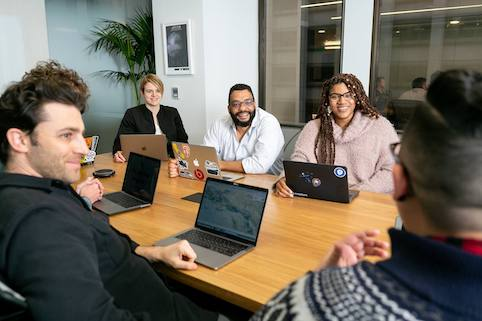

Первый этап обработки фото — детекция лиц на нем. Результат детекции может выглядеть примерно так:

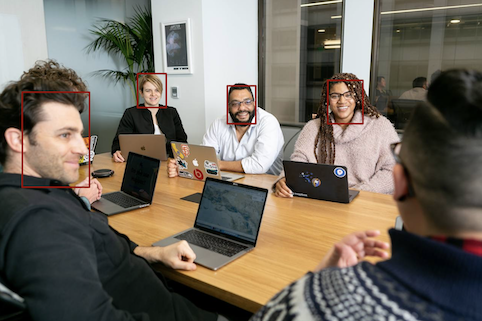

Для детекции лиц на фото может использоваться модель (например, нейросеть), обученная на задачу детекции лиц людей.

In [7]:
import cv2
import dlib
from google.colab.patches import cv2_imshow
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

--2024-05-21 17:44:23--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  18.1MB/s    in 3.9s    

2024-05-21 17:44:27 (15.8 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [8]:
image = cv2.imread('celebA_train_500/celebA_imgs/000001.jpg')
print(image)

[[[194 231 253]
  [194 231 253]
  [194 231 253]
  ...
  [216 228 246]
  [223 237 255]
  [222 238 254]]

 [[194 231 253]
  [194 231 253]
  [194 231 253]
  ...
  [218 230 248]
  [223 237 255]
  [222 238 254]]

 [[194 231 253]
  [194 231 253]
  [194 231 253]
  ...
  [220 232 250]
  [224 238 255]
  [223 239 255]]

 ...

 [[ 26  74 140]
  [  1  49 115]
  [ 33  78 146]
  ...
  [ 28  55 122]
  [ 30  56 123]
  [ 30  56 122]]

 [[ 14  61 129]
  [ 21  68 136]
  [ 51  96 164]
  ...
  [ 20  49 118]
  [ 24  50 120]
  [ 24  51 118]]

 [[ 56 103 171]
  [ 90 137 205]
  [131 176 244]
  ...
  [ 20  49 118]
  [ 24  50 120]
  [ 24  50 120]]]


56.22277118748239


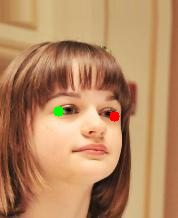

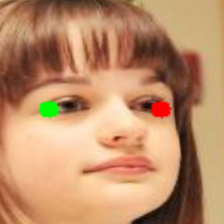

In [9]:
import numpy as np
# Загрузка предварительно обученного детектора лиц
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
# Загрузка изображения
image = cv2.imread('celebA_train_500/train/091464.jpg')

# Преобразование в оттенки серого (MTCNN может работать на одноканальных изображениях)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Обнаружение лиц с использованием MTCNN
faces = detector(gray)
test_image = image
# Отображение bounding boxes на изображении
for face in faces:
    x, y, w, h = face.left(), face.top(), face.width(), face.height()
    #cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    landmarks = predictor(image, face)
    left_eye = (landmarks.part(36).x, landmarks.part(36).y)
    right_eye = (landmarks.part(45).x, landmarks.part(45).y)
    dist = np.sqrt((left_eye[0]- right_eye[0])**2 + (left_eye[1]- right_eye[1])**2)
    angle = np.degrees(np.arctan2(right_eye[1] - left_eye[1], right_eye[0] - left_eye[0]))
    scale = image.shape[1] * 0.5/dist
    cv2.circle(image, left_eye, 5, (0, 255, 0), -1)
    cv2.circle(image, right_eye, 5, (0, 0, 255), -1)
    rotation_matrix = cv2.getRotationMatrix2D((face.center().x, face.center().y), angle, scale)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))
    print(dist)
    resized_image = cv2.resize(rotated_image, (224, 224))
    test_image = resized_image

cv2_imshow(image)
cv2_imshow(resized_image)


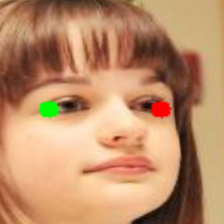

In [10]:
gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

# Обнаружение лиц с использованием MTCNN
faces = detector(gray)
# Отображение bounding boxes на изображении
for face in faces:
    x, y, w, h = face.left(), face.top(), face.width(), face.height()
    #cv2.rectangle(test_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    marks = predictor(test_image, face)
    left_eye = (marks.part(36).x, marks.part(36).y)
    right_eye = (marks.part(45).x, marks.part(45).y)
    dist = np.sqrt((left_eye[0]- right_eye[0])**2 + (left_eye[1]- right_eye[1])**2)
    cv2.circle(test_image, left_eye, 5, (0, 255, 0), -1)  # Зеленая точка для левого глаза
    cv2.circle(test_image, right_eye, 5, (0, 0, 255), -1)
    print(left_eye[0], left_eye[1], right_eye[0], right_eye[1])
    print(dist)
cv2_imshow(test_image)

#### Выравнивание лиц


После этапа детекции работа с каждым детектированным лицом идет по отдельности
(точнее, с bounding box'ами каждого детектированного лица).

Второй этап — выравнивание лица. Он состоит из двух этапов:
1. На картинке ищутся ключевые точки лица (обычно это координаты зрачков глаз, кончик носа и точки вокруг рта). Для этой задачи используется отдельная модель (возможно, тоже нейросеть). У PyTorch есть [туториал](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) с кодом и описанием того, как подобная модель работает;
2. Повернуть и растянуть изображение так, чтобы точки глаз лица лежали на заданной горизонтальной линии, и чтобы между зрачками глаз было определенное расстояние.

Вот так это может выглядеть:

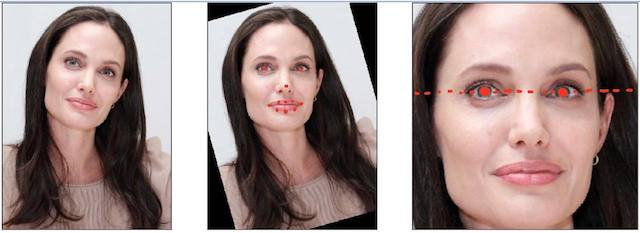

178 218


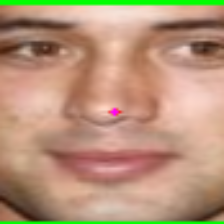

In [11]:
import numpy as np
# Загрузка предварительно обученного детектора лиц
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
image = cv2.imread('celebA_train_500/celebA_imgs/000007.jpg')

# Преобразование в оттенки серого (MTCNN только с одноканальными)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

faces = detector(gray)

# Отображение bounding boxes на изображении
for face in faces:
    x, y, w, h = face.left(), face.top(), face.width(), face.height()
    #cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    landmarks = predictor(image, face)
    left_eye = (landmarks.part(36).x, landmarks.part(36).y)
    right_eye = (landmarks.part(45).x, landmarks.part(45).y)
    dist = np.sqrt((left_eye[0]- right_eye[0])**2 + (left_eye[1]- right_eye[1])**2)
    angle = np.degrees(np.arctan2(right_eye[1] - left_eye[1], right_eye[0] - left_eye[0]))

    rotation_matrix = cv2.getRotationMatrix2D((face.center().x, face.center().y), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))
    cv2.circle(rotated_image, (face.center().x, face.center().y), 1, (0, 0, 255), -1)
    cv2.rectangle(rotated_image, (x, y), (x+w, y+h), (0, 0, 255), 2)
    print(image.shape[1], image.shape[0])

    udl_coef = 86/dist
    stretched_image = cv2.resize(rotated_image, ((int)(image.shape[1]* udl_coef), image.shape[0]))
    cv2.rectangle(stretched_image, ((int)(x * udl_coef), y), ((int)((x+w) *udl_coef), y+h), (0, 255, 0), 2)
    cv2.circle(stretched_image, ((int)(face.center().x * udl_coef), face.center().y), 1, (255, 0, 255), -1)
    resized_image = cv2.resize(stretched_image[y:(y+h), ((int)(face.center().x * udl_coef - h/2)):((int)(face.center().x * udl_coef + h/2))], (224, 224))
cv2_imshow(resized_image)


Таким образом, после второго этапа лица выглядят как-то так:

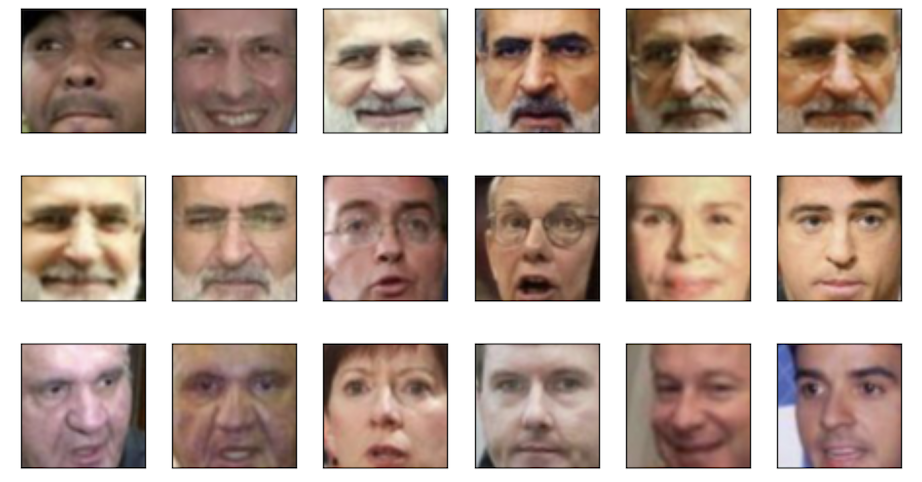

На таких картинках лиц и будет работать третья часть пайплайна — нейросеть, которая распознает лица.

#### Обучение модели с использованием FaceNet


In [12]:
transform = transforms.Compose([
      transforms.Resize(160),
      transforms.CenterCrop(160),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.3, 0.3, 0.3)),
])

transform_train = transforms.Compose([
      transforms.Resize(160),
      transforms.CenterCrop(160),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.3, 0.3, 0.3)),
      transforms.RandomHorizontalFlip(),
      transforms.RandomChoice([
                   transforms.RandomErasing(p=0.2, scale=(0.02, 0.3)),
                   transforms.GaussianBlur(kernel_size=(9, 9))
                    ])
])
train_dataset = CelebADataset(root_dir='celebA_train_500', dataset_type='train', transform=transform)
val_dataset = CelebADataset(root_dir='celebA_train_500', dataset_type='val', transform=transform)
test_dataset = CelebADataset(root_dir='celebA_train_500', dataset_type='test', transform=transform)

print("Train dataset length:", len(train_dataset))
print("Val dataset length:", len(val_dataset))
print("Test dataset length:", len(test_dataset))
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

Train dataset length: 8544
Val dataset length: 1878
Test dataset length: 1589


In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    losses = {'train': [], "val": []}
    accur = {'train': [], "val": []}
    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for data in tqdm(loader, leave=False, desc=f"{phase} iter:"):
                inputs, labels = data['image'], data['label']
                if use_gpu:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                else:
                    inputs, labels = inputs, labels

                if phase=="train":
                    optimizer.zero_grad()

                if phase == "val":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            losses[phase].append(epoch_loss)
            accur[phase].append(epoch_acc)

            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, losses, accur

In [14]:
torch.cuda.is_available()

True

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = InceptionResnetV1(classify=True, num_classes = 500)
model.last_linear = nn.Linear(in_features=1792, out_features=1024, bias=False)
model.last_bn = nn.BatchNorm1d(1024, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
model.logits = nn.Linear(in_features=1024, out_features=500, bias=True)

if torch.cuda.is_available():
  model = model.cuda()

loss_fn = nn.CrossEntropyLoss()
optimizer_ft = optim.AdamW(model.parameters(), lr=1e-3)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

In [16]:
model, losses, accur = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=35)
torch.save(model.state_dict(), 'model_CE.pt')

Epoch::   0%|          | 0/35 [00:00<?, ?it/s]

train iter::   0%|          | 0/86 [00:00<?, ?it/s]

NameError: name 'use_gpu' is not defined

NameError: name 'losses' is not defined

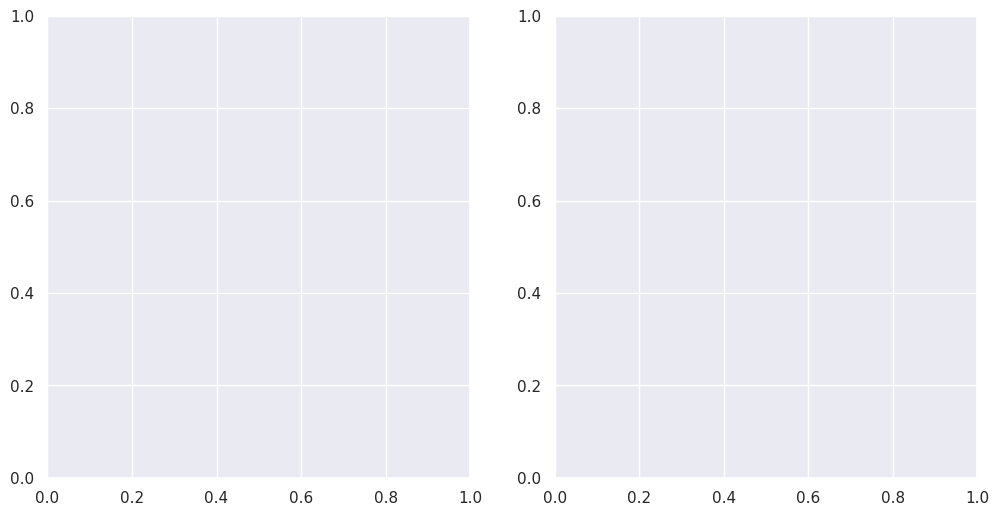

In [18]:
sns.set(font_scale=1.0)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(losses['train'], label="train")
axs[0].plot(losses['val'], label="val")
axs[0].legend()
axs[1].plot(accur['train'], label="train")
axs[1].plot(accur['val'], label="val")
axs[1].legend()
plt.legend()
plt.show()

In [19]:
def evaluate(model, dataloader, loss_fn):
    losses = []

    correct = 0
    count = 0

    for i, batch in enumerate(dataloader):

        X_batch, y_batch = batch['image'], batch['label']
        count += len(y_batch)

        with torch.no_grad():
            logits = model(X_batch.to(device))

            loss = loss_fn(logits, y_batch.to(device))
            losses.append(loss.item())

            y_pred = torch.argmax(logits, dim=1)

            correct += torch.sum(y_pred.cpu() == y_batch)

    return correct / count

In [20]:
test_accuracy = evaluate(model, test_loader, loss_fn)
print(f'test_accuracy: {test_accuracy}')

test_accuracy: 0.0012586532393470407


#### Распознавание лиц

Третья часть пайплайна — это, собственно, распознавание лиц.

Что такое "распознавание": мы хотим построить такую нейросеть, которая принимает на вход картинку лица, а выдает вектор определенного размера. И мы хотим, чтобы векторы лиц одного и того же человека были близки по некоторому расстоянию (например, косинусному), а векторы лиц разных людей были далеки по этому же расстоянию. Обычно в качестве расстояния используется [косинусное расстояние](https://en.wikipedia.org/wiki/Cosine_similarity) (cosine distance).

Почему мы хотим построить именно такую сеть? Почему не посмтроить обычную сеть для классификации и научить ее классифицировать лица из обучающей выборки, где каждый отдельный человек — это один класс? Ответ такой — мы хотим, чтобы наша модель умела работать с лицами людей, которых нет в обучающей выборке. Хотим, чтобы она на лица одного и того же незнакомого человека выдавала близкие векторы (т.е. "говорила" нам, что это один и тот же человек), а на лица разных людей — далекие векторы.

Пусть тогда у нас есть база данных людей вида (id, набор векторов его лиц). Когда к нам придет новая картинка лица, мы ее прогоним через модель и получим вектор этого лица. Далее сравним этот вектор по метрике расстояния с векторами из нашей базы. Тот id, чьи векторы будут наиболее близки к нашему, и будет ответом на вопрос "кто изображен на картинке"



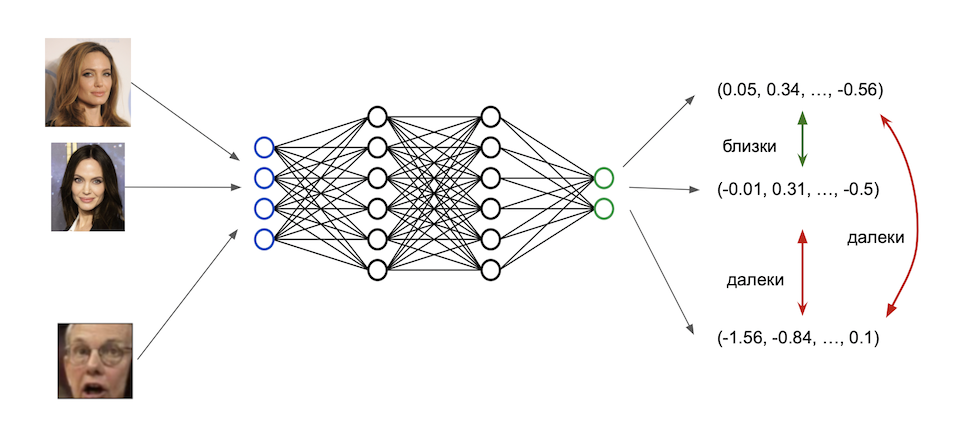

Такую сеть можно обучать разными способами. Два самых распространенных — такие:

1. Можно обучить нейросеть на обучающей выборке лиц на задачу классификации. Каждый отдельный человек — это один класс. В качестве лосс-функции можно использовать стандартную кросс-энтропию или специальные ее модификации (разберем ниже в ноутбуке). Затем, после обучения сети, выкинуть последний слой и считать вектором лица выход предпоследнего слоя сети. Это будет работать: полученные таким образом векторы лиц действительно будут близки для лиц одного и того же человека, и далеки для лиц разных людей. Причем это будет работать даже на тех лицах, которые не было в обучающей выборке (при условии, что обучающая выборка достаточно велика).

    У этого подхода есть недостаток: классов в обучающем датасете может быть очень много. Из-за этого последний слой сети станет очень широким. Это сделает обучение сети вычислительно затратным и сложным по памяти. Иногда приходится этот последний слой делить на несколько разных GPU, настолько он бывает большим.
2.  Можно пойти другим путем: обучать сеть напрямую на задачу "выдавать похожие эмбеддинги для лиц одного и того же человека, и далекие эмбеддинги для лиц разных людей". Это называется **contrastive training**.
    
    На каждой итерации обучения тогда происходит следующее:
    - берется картинка лица, к ней выбирается позитивная пара (еще одна картинка лица того же человека) и негативная (картинка лица другого человека). Все три картинки подаются на вход сети, на выходе получаются три вектора. Далее считается расстояние между векторами 1 и 2 и расстояние между векторами 1 и 3. Нейросеть обучается так, чтобы расстояние между векторами 1 и 2 было как можно меньше, а расстояние между векторами 1 и 3 — как можно больше.

    Лосс-функция в этом случае выглядит так:

 $$L = D(anchor, positive) - D(anchor, negative)$$

У contrastive loss тоже есть недостаток: его достаточно сложно настроить (подобрать к нему гиперпараметры).

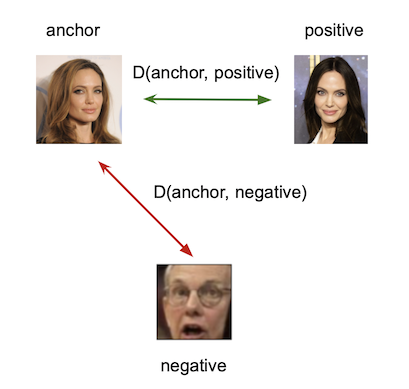

Вот так устроен пайплайн распознавания лиц, который мы хотим получить. Заметим, что все три части пайплайна обучаются отдельно.
- первая часть — это просто задача детекции;
- вторая часть — задача выравнивания фотографии лица;
- третья часть — задача распознавания лица по выровненной фотографии.

In [21]:
model.load_state_dict(torch.load('gdrive/MyDrive/model_CE.pt'))
model.classify = False
model.eval()
model = model.to(device)

In [22]:
def cosine_similarity(v1, v2):
    norm_v1 = torch.sqrt(torch.sum(v1*v1))
    norm_v2 = torch.sqrt(torch.sum(v2*v2))
    v = torch.sum(v1*v2)
    return (v / (norm_v1*norm_v2)).item()

def matrix_similarity(T1, T2):
    a, b = T1.norm(dim=1)[:, None], T2.norm(dim=1)[:, None]
    T1 = T1 / torch.max(a, 1e-5*torch.ones_like(a))
    T2 = T2 / torch.max(b, 1e-5*torch.ones_like(b))
    matrix = torch.mm(T1, T2.transpose(0, 1))
    return matrix.cpu().numpy()

In [71]:
def get_image(x):
    image_tensor = x["image"]
    image_array = image_tensor.numpy()
    image_array = np.transpose(image_array, (2, 3, 1, 0))
    image = image_array[:, :, :, 0]
    image = np.clip(image, 0, 1)
    return image

In [72]:
def plot(train_dict, test_dict, res_cs, min_img=4, dist=False):
  if not dist:
    size = min(min_img, min(len(train_dict), len(test_dict)))
    res_cs = []
    for i in range(size):
        res1 = model(train_dict[i][1]["image"].to(device))
        res2 = model(test_dict[i][1]["image"].to(device))
        res_cs.append(cosine_similarity(res1, res2))


    f, axes= plt.subplots(2, size, figsize=(3*size, 7))
    for i in range(size):
        image = get_image(train_dict[i][1])
        axes[0][i].imshow(image, cmap='gray')
        axes[0][i].axis('off')
        image = get_image(test_dict[i][1])
        axes[1][i].imshow(image, cmap = 'gray')
        axes[1][i].axis('off')
        axes[1][i].set_title("cosine_sim = " + f"{res_cs[i]:.3f}")

    for i, ax in enumerate(axes.flat):
        if i == 0:
            ax.set(ylabel = 'From train data')
        if i == size:
            ax.set(ylabel = 'From test data')

    plt.show()
  else:
    size = min(len(train_dict), len(test_dict))
    for i in range(size):
        res1 = model(train_dict[i][1]["image"].to(device))
        res2 = model(test_dict[i][1]["image"].to(device))
        res_cs.append(cosine_similarity(res1, res2))
    return res_cs

In [24]:
person = torch.randint(0, 499, (1, 1)).item()
loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)
loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
train_dict = []
test_dict = []

for i, train in enumerate(loader_train):
    if person == train['label'].item():
        train_dict.append((i, train))
for i, test in enumerate(loader_test):
    if person == test['label'].item():
        test_dict.append((i, test))

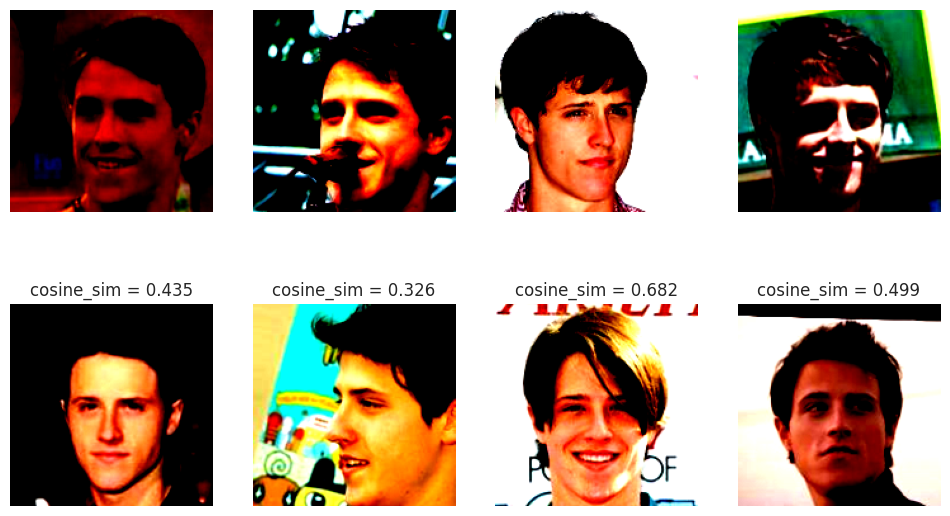

In [73]:
plot(train_dict, test_dict, [])

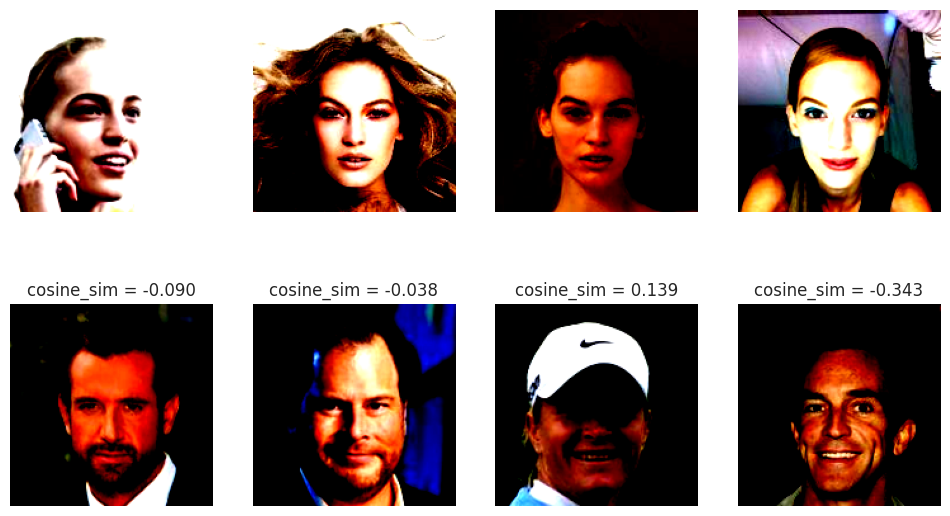

In [75]:
train_dict = []
test_dict = []
person_1 = torch.randint(249, 499, (1, 1)).item()

for i, train in enumerate(loader_train):
    if person_1 == train['label'].item():
        train_dict.append((i, train))

for i, test in enumerate(loader_test):
    person_2 = torch.randint(0, 249, (1, 1)).item()
    if test['label'].item() == person_2:
        test_dict.append((i, test))

plot(train_dict, test_dict, [])

При обучении модели для распознавания лиц с помощью CE (кросс-энтропии) мы можем считать метрику accuracy как индикатор того, насколько хорошо наша модель работает. Но у accuracy тут есть недостаток: она не сможет померить, насколько хорошо наша модель работает на лицах людей, которых нет в обучающей выборке.  

Чтобы это исправить, придумали новую метрику: **identification rate**. Вот как она работает:

Создадим два набора изображений лиц: query и distractors. Никакие лица из этих наборов не должны содержаться в обучающем и валидационном датасете.

1. посчитаем косинусные расстояния между лицами, соответствующими одним и тем же людям из query части. Например, пусть одному человеку соответствуют три фото в query: 01.jpg, 02.jpg, 03.jpg. Тогда считаем три косинусных расстояния между всеми тремя парами из этих фото.
2. посчитаем косинусные расстояния между лицами, соответствующими разным людям из query части.
3. посчитаем косинусные расстояния между всеми парами лиц из query и distractors. Т.е. пара — это (лицо из query, лицо из distractors). Всего получится |query|*|distractors| пар.
4. Сложим количества пар, полученных на 2 и 3 шагах. Это количество false пар.
5. Зафиксируем **FPR** (false positive rate). Пусть, например, будет 0.01. FPR, умноженный на количество false пар из шага 4 — это разрешенное количество false positives, которые мы разрешаем нашей модели. Обозначим это количество через N.
6. Отсортируем все значения косинусных расстояний false пар. N — ое по счету значение расстояния зафиксируем как **пороговое расстояние**.
7. Посчитаем количество positive пар с шага 1, которые имеют косинусное расстояние меньше, чем пороговое расстояние. Поделим это количество на общее количество positive пар с шага 1. Это будет TPR (true positive rate) — итоговое значение нашей метрики.

Такая метрика обычно обозначается как TPR@FPR=0.01. FPR может быть разным. Приразных FPR будет получаться разное TPR.

Смысл этой метрики в том, что мы фиксируем вероятность ошибки вида false positive, т.е. когда "сеть сказала, что это один и тот же человек, но это не так", считаем порог косинусного расстояния для этого значения ошибки, потом берем все positive пары и смотрим, у скольких из них расстояние меньше этого порога. Т.е. насколько точно наша сеть ищет похожие лица при заданной вероятности ошибки вида false positive.

#### ArcFace Loss (Additive Angular Margin Loss)

В случае с обучением на задачу классификации лосс-функция, которая нам приходит в голову — Cross-Entropy. И на нее действительно можно обучать сеть для распознавания лиц. Но за много лет люди придумали более хитрые лосс-функции, которые делают обучение сети для распознавания лиц более эффективным. Одним из лучших считается ArcFace Loss (Additive Angular Margin Loss).

Этот лосс — чуть измененная кросс-энтропия. Он позволяет достичь лучшего распределения векторов лиц на сфере. В нем добавлены некоторые дополнительные ограничения и гиперпараметры, для того чтобы эмбеддинги лиц одного класса были более близки между собой, а эмбеддинги лиц разных людей оставались далеки. То есть, этот лосс позволяет лучше кластеризовать лица на сфере единичного радиуса.


**Как устроен ArcFace**:

Стандартные SoftMax + кросс-энтропия (CE) выглядят так:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

здесь:
- $x_i \in \mathbb{R^d}$ — вектор $i$-го элемента обучающей выборки перед последним полносвязным слоем сети. $y_i$ — класс этого элемента;
- $W_j \in \mathbb{R^d}$ — j-ый столбец матрицы весов последнего слоя сети (т.е. слоя, который производит итоговую классификацю входящего объекта);
- $b_j \in \mathbb{R^d}$ — j-ый элемент вектора байеса последнего слоя сети;
- $N$ — batch size;
- $n$ — количество классов.


Хотя этот лосс работает хорошо, он явным образом не заставляет эмбеддинги $x_i$ элементов, принадлежащих одному классу, быть близкими друг к другу по расстоянию. И не заставляет эмбеддинги элементов, принадлежащих разным классам, быть далеко друг от друга. Все, что хочет этот лосс — чтобы на основе эмбеддингов $x_i$ можно было хорошо классифицировать элементы, никакие ограничений на расстояния между эмбеддингами $x_i$ он не вводит.

Из-за этого у нейросетей для распознавания лиц, которые обучены на обычном CE loss, бывают проблемы с распознаванием лиц, которые сильно отличаются от лиц того же человека разными допатрибутами (шляпа/прическа/очки и т.п.). Просто эмбеддинг для таких лиц получается довольно далек по расстоянию от других эмбеддингов лиц этого же человека.

Давайте теперь немного поправим формулу:
- уберем байес последнего слоя, т.е. сделаем $b_j=0$;
- нормализуем веса последнего слоя: ||$W_j$|| = 1;
- нормализуем эмбеддинги: ||$x_i$|| = 1. Перед подачей их на вход последнему слою (т.е. перед умножением на матрицу $W_j$) умножим их на гиперпараметр s. По сути, мы приводим норму всех эмбеддингов к s. Смысл этого гиперпараметра в том, что, возможно, сети проще будет классифицировать эмбеддинги, у которых не единичная норма.

Нормализация эмбеддингов приводит к тому, что эмбеддинги начинают быть распределены по сфере единичного радиуса (и сфере радиуса s после умножения на ниперпараметр s). И итоговые предсказания сети после последнего слоя зависят только от угла между эмбеддингами $x_i$ и выученных весов $W_j$. От нормы эмбеддинга $x_i$ они больше не зависят, т.к. у всех эмбеддингов они теперь одинаковые.

Получается, в степени экспоненты у нас останется выражение $s W_{y_i}^{T}x_i$, которое можно переписать в виде  $s W_{y_i}^{T}x_i = s ||W_{y_i}||\cdot ||x_i|| \cdot cos\Theta_{y_i}$. Тут $\Theta_{y_i}$ — это угод между векторами $W_{y_i}$ и $x_i$. Но так как мы сделали нормы $W_{y_i}$ и $x_i$ единичными, то все это выражение просто будет равно $s cos\Theta_{y_i}$.

В итоге мы получим следующую формулу лосса:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$


И последний шаг. Добавим еще один гиперпараметр $m$. Он называется additive angular margin penalty и заставляет эмбеддинги одного класса быть ближе друг к другу, а эмбеддинги разных классов — более далекими друг от друга.

В итоге получим вот что:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Это и есть ArcFace Loss с двумя  гиперпараметрами, s и m.

Получается, что ArcFace Loss завтавляет сеть выучивать эмбеддинги, распределенные по сфере радиуса s, причем чтобы эмбеддинги одного класса были ближе друг к другу, а эмбеддинги разных классов — более далеки друг от друга.



In [ ]:
class ArcFace_celebADataset(Dataset):
    def __init__(self, files, labels, transform):
        self.transform = transform
        self.files = files
        self.labels = labels

    def __len__(self):
        return len(self.files)

    def load_sample(self, name_img):
        image = Image.open(img_path / name_img)
        image.load()
        return image

    def __getitem__(self, idx):
        x = self.load_sample(self.files[idx])
        x = self.transform(x)
        return x, self.labels[idx]

transform = transforms.Compose([
      transforms.Resize(160),
      transforms.CenterCrop(160),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.3, 0.3, 0.3)),
])

train_full = ArcFace_celebADataset(img_train, label_train, transform)
test_full = ArcFace_celebADataset(img_test, label_test, transform)

batch_size = 100
train_loader = torch.utils.data.DataLoader(train_full, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_full, batch_size=batch_size, shuffle=False)

dataset_sizes = {
    'train': len(train_full),
    'val': len(test_full)
}